<a href="https://colab.research.google.com/github/atropass/pan-sharpening/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [30]:
# high-resolution grayscale
gray_image = cv2.imread('GRAY.JPG', cv2.IMREAD_GRAYSCALE)

# lower-resolution colored images
rgb_half_image = cv2.imread('RGB_half.JPG')
rgb_quater_image = cv2.imread('RGB_quater.JPG')

1. Align the images
2. Resize the images
3. Color restoration
4. Comparing the results

In [33]:
#SIFT detector
sift = cv2.SIFT_create()

In [34]:
# detecting features using SIFT
keypoints_gray, descriptors_gray = sift.detectAndCompute(gray_image, None)
keypoints_half, descriptors_half = sift.detectAndCompute(rgb_half_image, None)
keypoints_quarter, descriptors_quarter = sift.detectAndCompute(rgb_quater_image, None)

In [35]:
#feature matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [36]:
#match descriptors between grayscale and color images
matches_half = bf.match(descriptors_gray, descriptors_half)
matches_quarter = bf.match(descriptors_gray, descriptors_quarter)

In [37]:
#sorting matches based ondistance
matches_half = sorted(matches_half, key = lambda x:x.distance)
matches_quarter = sorted(matches_quarter, key = lambda x:x.distance)

So, using SIFT I detected keypoints and descriptors of all images, after usinn Brute Force mathcing ( bruteforce in this case good because straightforward and actually these images are the same with some rotation )

In [38]:
#good matches
points_gray_half = np.zeros((len(matches_half), 2), dtype=np.float32)
points_half = np.zeros((len(matches_half), 2), dtype=np.float32)

In [39]:
for i, match in enumerate(matches_half):
    points_gray_half[i, :] = keypoints_gray[match.queryIdx].pt
    points_half[i, :] = keypoints_half[match.trainIdx].pt

In [41]:
#find homography
h_half, _ = cv2.findHomography(points_half, points_gray_half, cv2.RANSAC)

In [42]:
points_gray_quarter = np.zeros((len(matches_quarter), 2), dtype=np.float32)
points_quarter = np.zeros((len(matches_quarter), 2), dtype=np.float32)

In [43]:
for i, match in enumerate(matches_quarter):
    points_gray_quarter[i, :] = keypoints_gray[match.queryIdx].pt
    points_quarter[i, :] = keypoints_quarter[match.trainIdx].pt

In [44]:
h_quarter, _ = cv2.findHomography(points_quarter, points_gray_quarter, cv2.RANSAC)

In [45]:
aligned_half = cv2.warpPerspective(rgb_half_image, h_half, (gray_image.shape[1], gray_image.shape[0]))
aligned_quarter = cv2.warpPerspective(rgb_quater_image, h_quarter, (gray_image.shape[1], gray_image.shape[0]))

here, I computer homography for both images ( out transformation matrix ) and after aligned it to our grayscale image and it rotated 2 images properly


Pan sharpening

In [46]:
# converting from RBG to HSV color space
hsv_half = cv2.cvtColor(aligned_half, cv2.COLOR_BGR2HSV)
hsv_quarter = cv2.cvtColor(aligned_quarter, cv2.COLOR_BGR2HSV)

In [47]:
hsv_half[:, :, 2] = gray_image
hsv_quarter[:, :, 2] = gray_image

In [48]:
pan_sharpened_half = cv2.cvtColor(hsv_half, cv2.COLOR_HSV2BGR)
pan_sharpened_quarter = cv2.cvtColor(hsv_quarter, cv2.COLOR_HSV2BGR)

here, I used pan sharpening, firstly converted our 2 images to HSV and after replaced V (value) channel with our grayscale image. keeping hue and saturation of images

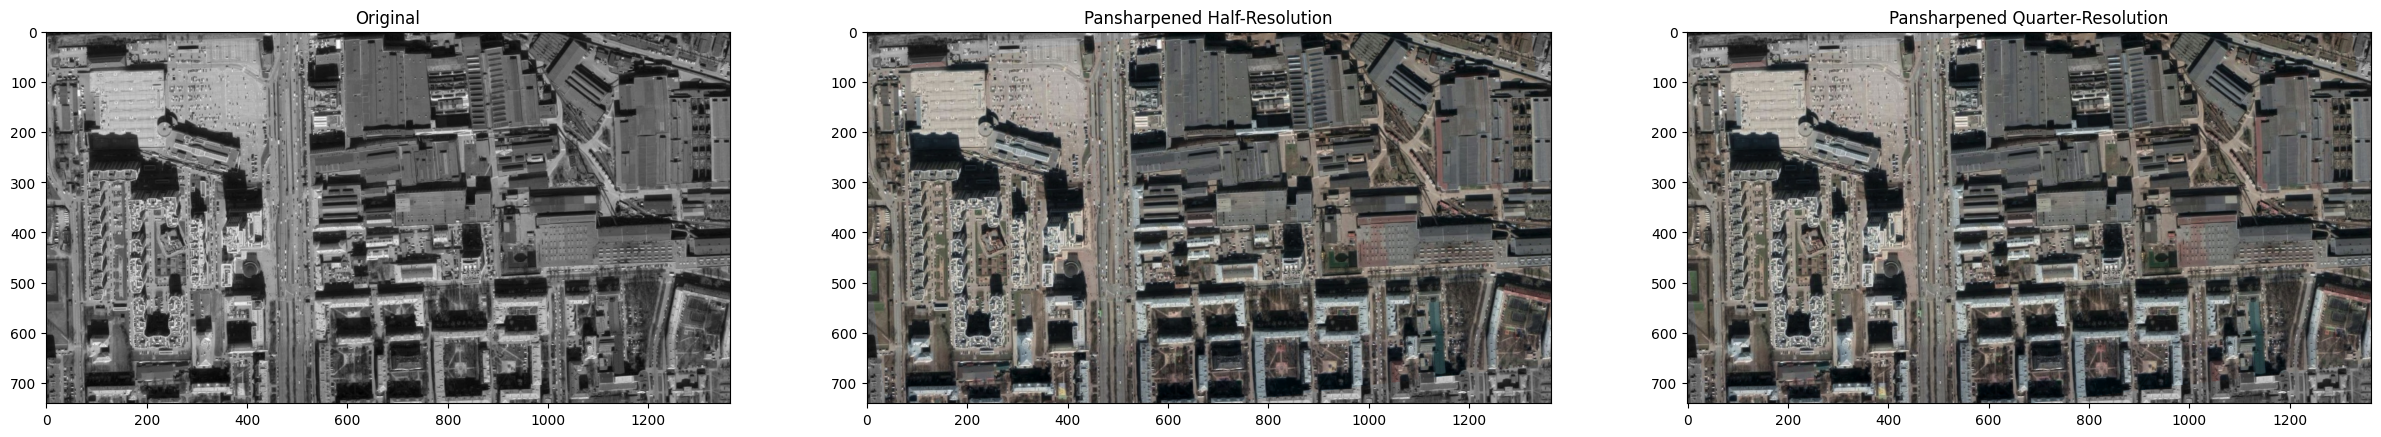

In [53]:
plt.figure(figsize=(30,15))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB))
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(pan_sharpened_half, cv2.COLOR_BGR2RGB))
plt.title('Pansharpened Half-Resolution')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(pan_sharpened_quarter, cv2.COLOR_BGR2RGB))
plt.title('Pansharpened Quarter-Resolution')
plt.show()

In [51]:
cv2.imwrite('pan_sharpened_half.JPG', pan_sharpened_half)
cv2.imwrite('pan_sharpened_quarter.JPG', pan_sharpened_quarter)


True

Seeing the results closely I saw improvement in the quality of our 2 images (with colors). The quality of quarter and half are almost identical because the main source of spatial information in both is the same high-resolution grayscale image.